In [1]:
import numpy as np
from jax import jacfwd
import jax.numpy as jnp
import project_2 as p2
import seaborn as sns
from tqdm import tqdm
import imp
imp.reload(p2)
sns.set(context='paper',style='darkgrid')

# Problem setup:

## States:

$$
x(t) = \left[ 
        \Re\{\bar{V}_1(t)\},
        \Im\{\bar{V}_1(t)\},
        c_g(t),
        s_g(t),
        \delta_g(t),
        \omega_g(t),
        \Re\{\bar{V}_2(t)\},
        \Im\{\bar{V}_2(t)\},
        c_m(t),
        s_m(t),
        \delta_m(t),
        \omega_m(t)
    \right]^T
$$

## System Parameters and Initial Conditions:

In [2]:
bg = 4.9 
Hg = 2.5 #seconds
Hm = 1.8
Sm = 1.0
bm = 5.8
Sg = 1
b = 7.5
g = 0.95
omega0 = 2*np.pi*60
#By fiat
Pgm = 0.75
Pmm = 0.75
Im = 0.75 * np.exp(0*1j)
Ig = 0.75 * np.exp(np.deg2rad(180)*1j)
Eg = 1.0315 * np.exp(np.deg2rad(14.2)*1j)
Em = 1/(bm*-1j)*(-1*Im) +1
V1 = 1/(b*-1j)*Im + 1
V2 = 1.0*np.exp(0*1j)


In [3]:
cycles = [i for i in range(14)]
times = [n*(1/60) for n in cycles]

## Measurements 

In [4]:
measurements  = np.array([[1.000, 0.100, 1.000, 0.000, 0.750, 0.000, -0.750, 0.000,-0.750, 0.000, 0.750, 0.000, 0.000, 0.000],
                          [1.000, 0.100, 1.000, 0.000, 0.750, 0.000, -0.750, 0.000, -0.750, 0.000, 0.750, 0.000, 0.000, 0.000,],
                          [0.993, 0.030, 0.987, -0.114, 1.079, -0.041, -1.079, 0.041, -1.079, 0.041, 0.141, 0.068, -0.392, -1.092],
                          [0.991, 0.013, 0.983, -0.135, 1.111, -0.060, -1.111, 0.060, -1.111, 0.060, 0.177, 0.068, -0.811, -2.146],
                          [0.988, -0.014, 0.975, -0.169, 1.160, -0.095, -1.160, 0.095,-1.160, 0.095, 0.233, 0.065, -1.278, -3.125],
                          [0.982, -0.052, 0.963, -0.215, 1.219, -0.148, -1.219, 0.148,-1.219, 0.148, 0.305, 0.056, -1.813, -4.001],
                          [0.974, -0.101, 0.944, -0.271, 1.281, -0.222, -1.281, 0.222, -1.281, 0.222, 0.384, 0.036, -2.425, -4.757],
                          [0.960, -0.159, 0.918, -0.337, 1.335, -0.318, -1.335, 0.318, -1.335, 0.318, 0.464, 0.002, -3.118, -5.387],
                          [0.941, -0.226, 0.883, -0.409, 1.372, -0.436, -1.372, 0.436, -1.372, 0.436, 0.534, -0.047, -3.888, -5.896],
                          [0.915, -0.302, 0.838, -0.487, 1.382, -0.572, -1.382, 0.572, -1.382, 0.572, 0.586, -0.110, -4.723, -6.300],
                          [0.916, -0.334, 0.844, -0.482, 1.106, -0.538, -1.106, 0.538, -1.106, 0.538, 1.106, -0.538, -5.609, -6.622],
                          [0.877, -0.424, 0.790, -0.565, 1.055, -0.652, -1.055, 0.652, -1.055, 0.652, 1.055, -0.652, -6.175, -5.836],
                          [0.832, -0.512, 0.734, -0.640, 0.959, -0.735, -0.959, 0.735, -0.959, 0.735, 0.959, -0.735, -6.730, -5.067],
                          [0.780, -0.597, 0.676, -0.707, 0.828, -0.778, -0.828, 0.778, -0.828, 0.778, 0.828, -0.778, -7.226, -4.377]
                         ])

In [5]:
P = 100e6*np.eye(8)
W = (1/(0.01**2))*np.eye(measurements.shape[1])

## Dynamic State Estimation

In [6]:
def d_vec(x_k,x_k_h,z):
    h_x = np.asarray(p2.h(x_k))-z
    g_x_k = p2.g_cons(x_k,x_k_h)
    d = np.concatenate([h_x,g_x_k])
    return d

def update_rule(x_k,H,G,W,P,d):
    x_k_1 = x_k - np.linalg.inv(H.T@W@H + G.T@P@G)@(np.hstack([H.T@W,G.T@P]))@d
    return x_k_1


In [7]:
#cg = cos(angle(eg))
#cm = cos(angle(em))
#sg = sin(angle(eg))
#sm = sin(angle(em))
x_k = np.array([np.real(V1),np.imag(V1),np.cos(np.angle(Eg)),np.sin(np.angle(Eg)),np.angle(Eg),0,np.real(V2),np.imag(V2),np.cos(np.angle(Em)),np.sin(np.angle(Em)),np.angle(Em),0])
print(x_k)

[ 1.          0.1         0.96944535  0.24530739  0.24783675  0.
  1.          0.          0.99174283 -0.12824261 -0.12859675  0.        ]


In [8]:
print(p2.g_cons(x_k,x_k))

[-2.0370767953945684e-06, 0.0, 0.0, 0.0, -1.734723475976807e-18, 0.0, 0.0, 0.0]


In [9]:
np.abs(p2.Em)

1.0083259221498917

In [10]:
X = []
tol = 1e-6
k = 0
# z = measurements[0,:]

# H = p2.measurement_jacobian(x_k)
# G = p2.constraint_jacobian(x_k,x_k)
# d = d_vec(x_k,x_k,z)
#x_k = update_rule(x_k,H,G,W,P,d)
x_k_h = x_k

In [11]:
g = p2.g_cons(x_k,x_k_h)
print(g)

[-2.0370767953945684e-06, 0.0, 0.0, 0.0, -1.734723475976807e-18, 0.0, 0.0, 0.0]


In [12]:
x_k

array([ 1.        ,  0.1       ,  0.96944535,  0.24530739,  0.24783675,
        0.        ,  1.        ,  0.        ,  0.99174283, -0.12824261,
       -0.12859675,  0.        ])

In [13]:

for z,t in enumerate(measurements):
    print("==============================t= ",t)
    for i in tqdm(range(10)):
        
        #print(x_k)
        H = p2.measurement_jacobian(x_k)
        G = p2.constraint_jacobian(x_k,x_k_h)
        #print(H,G)
        d = d_vec(x_k,x_k_h,z)
        x_k = update_rule(x_k,H,G,W,P,d)
       
        #print(d[14:])
    print(x_k)
    X.append(x_k)
    x_k_h = x_k

  0%|          | 0/10 [00:00<?, ?it/s]

==============================t=  [ 1.    0.1   1.    0.    0.75  0.   -0.75  0.   -0.75  0.    0.75  0.
  0.    0.  ]


 10%|█         | 1/10 [00:00<00:01,  5.28it/s]

[ 0.96507505  0.05571246  0.96952528  0.2441526   0.24716033 -0.08117078
  0.96647985  0.01318317  0.99167161 -0.12743421 -0.12826674  0.03960169]
==============================t=  [ 1.    0.1   1.    0.    0.75  0.   -0.75  0.   -0.75  0.    0.75  0.
  0.    0.  ]


 10%|█         | 1/10 [00:00<00:01,  5.28it/s]

[ 0.81424611  0.28953431  0.96834274  0.24854054  0.25220443  0.68646307
  0.81864991  0.23930382  0.99277482 -0.11746545 -0.11887085  1.08790501]
==============================t=  [ 0.993  0.03   0.987 -0.114  1.079 -0.041 -1.079  0.041 -1.079  0.041
  0.141  0.068 -0.392 -1.092]


 10%|█         | 1/10 [00:00<00:01,  5.22it/s]

[ 0.67147464  0.43564957  0.96178181  0.27265728  0.27776293  2.38055697
  0.67516427  0.37920158  0.99592661 -0.08424691 -0.08616877  2.83634476]
==============================t=  [ 0.991  0.013  0.983 -0.135  1.111 -0.06  -1.111  0.06  -1.111  0.06
  0.177  0.068 -0.811 -2.146]


  0%|          | 0/10 [00:00<?, ?it/s]

[ 0.53930435  0.58328297  0.94483402  0.3260025   0.33443897  4.42056729
  0.54236103  0.5234359   0.99886964 -0.02122788 -0.02358149  4.6741279 ]
==============================t=  [ 0.988 -0.014  0.975 -0.169  1.16  -0.095 -1.16   0.095 -1.16   0.095
  0.233  0.065 -1.278 -3.125]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.42319189 0.74930555 0.91076386 0.41052724 0.4265425  6.63185664
 0.42631145 0.68597751 0.99577084 0.07277648 0.07031503 6.59345452]
==============================t=  [ 0.982 -0.052  0.963 -0.215  1.219 -0.148 -1.219  0.148 -1.219  0.148
  0.305  0.056 -1.813 -4.001]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.328718   0.94422248 0.84986837 0.5233599  0.55614754 8.92074817
 0.33322214 0.87488711 0.97742598 0.19811393 0.19731418 8.64644429]
==============================t=  [ 0.974 -0.101  0.944 -0.271  1.281 -0.222 -1.281  0.222 -1.281  0.222
  0.384  0.036 -2.425 -4.757]


  0%|          | 0/10 [00:00<?, ?it/s]

[ 0.25629362  1.18599062  0.7504628   0.65582487  0.72369034 11.18438802
  0.26527655  1.10690693  0.93086756  0.35285936  0.35979233 10.85093382]
==============================t=  [ 9.600e-01 -1.590e-01  9.180e-01 -3.370e-01  1.335e+00 -3.180e-01
 -1.335e+00  3.180e-01 -1.335e+00  3.180e-01  4.640e-01  2.000e-03
 -3.118e+00 -5.387e+00]


  0%|          | 0/10 [00:00<?, ?it/s]

[ 0.19100311  1.50150413  0.60213319  0.79181626  0.92742698 13.26400831
  0.21062716  1.40992454  0.83989518  0.52949969  0.55984328 13.15517955]
==============================t=  [ 0.941 -0.226  0.883 -0.409  1.372 -0.436 -1.372  0.436 -1.372  0.436
  0.534 -0.047 -3.888 -5.896]


  0%|          | 0/10 [00:00<?, ?it/s]

[ 0.08972352  1.9156419   0.40140398  0.90797311  1.16233623 14.92510151
  0.1289562   1.81348483  0.68835799  0.71086933  0.79777349 15.39644564]
==============================t=  [ 0.915 -0.302  0.838 -0.487  1.382 -0.572 -1.382  0.572 -1.382  0.572
  0.586 -0.11  -4.723 -6.3  ]


  0%|          | 0/10 [00:00<?, ?it/s]

[-0.1220975   2.42318525  0.15795833  0.97845336  1.41910325 15.88694151
 -0.05570978  2.32047888  0.46795828  0.86802091  1.0699258  17.26183225]
==============================t=  [ 0.916 -0.334  0.844 -0.482  1.106 -0.538 -1.106  0.538 -1.106  0.538
  1.106 -0.538 -5.609 -6.622]


  0%|          | 0/10 [00:00<?, ?it/s]

[-0.52245708  2.95502365 -0.10347419  0.98485228  1.68418091 15.92237726
 -0.43065418  2.86801986  0.18921708  0.96541213  1.36636433 18.31079072]
==============================t=  [ 0.877 -0.424  0.79  -0.565  1.055 -0.652 -1.055  0.652 -1.055  0.652
  1.055 -0.652 -6.175 -5.836]


  0%|          | 0/10 [00:00<?, ?it/s]

[-1.12951374  3.37958108 -0.35021868  0.92606398  1.9418439  14.99718205
 -1.02748287  3.3203041  -0.11305373  0.97687527  1.67011771 18.13961554]
==============================t=  [ 0.832 -0.512  0.734 -0.64   0.959 -0.735 -0.959  0.735 -0.959  0.735
  0.959 -0.735 -6.73  -5.067]


  0%|          | 0/10 [00:00<?, ?it/s]

[-1.85497856  3.57428725 -0.55528486  0.81943288  2.17799592 13.34106015
 -1.76350517  3.53957919 -0.39106855  0.90371978  1.96007998 16.65585675]
==============================t=  [ 0.78  -0.597  0.676 -0.707  0.828 -0.778 -0.828  0.778 -0.828  0.778
  0.828 -0.778 -7.226 -4.377]


100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

[-2.54595254  3.51805038 -0.70733712  0.69095077  2.38377727 11.35270155
 -2.47728107  3.49157389 -0.60844857  0.77617888  2.21741758 14.22465485]


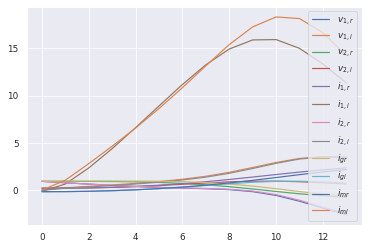

In [14]:
import matplotlib.pyplot as plt
X = np.asarray(X)
names = ['$v_{1,r}$','$v_{1,i}$','$v_{2,r}$','$v_{2,i}$','$i_{1,r}$','$i_{1,i}$','$i_{2,r}$','$i_{2,i}$','$i_{gr}$','$i_{gi}$','$i_{mr}$','$i_{mi}$','$\omega_g$','$\omega_m$']
for i in range(12):
    name = names[i]
    plt.plot(X[:,i],label=name)
plt.legend()

Text(0.5, 1.0, 'Voltages')

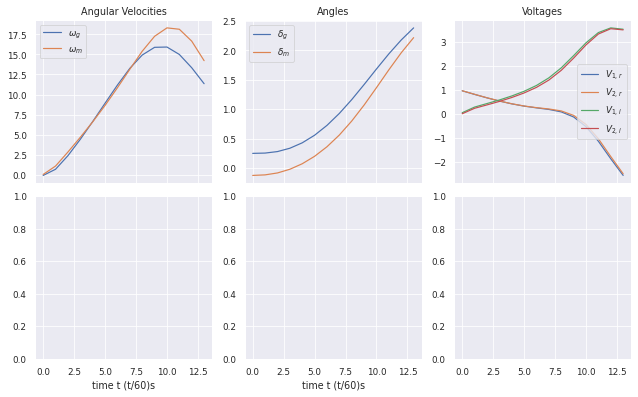

In [20]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(2.5*3.5,2.5*3.5/1.61828),constrained_layout=True,sharex=True)
axes[1,0].set_xlabel("time t (t/60)s")
axes[1,1].set_xlabel("time t (t/60)s")

#Generator and motor speed
axes[0,0].plot([p2.omegag(x) for x in X],label="$\omega_g$")
axes[0,0].plot([p2.omegam(x) for x in X],label="$\omega_m$")
axes[0,0].legend()
axes[0,0].set_title("Angular Velocities")
#Deltas
axes[0,1].plot([p2.deltag(x) for x in X],label="$\delta_g$")
axes[0,1].plot([p2.deltam(x) for x in X],label="$\delta_m$")
axes[0,1].legend()
axes[0,1].set_title("Angles")
#Voltages
axes[0,2].plot([p2.v1r(x) for x in X],label="$V_{1,r}$")
axes[0,2].plot([p2.v2r(x) for x in X],label="$V_{2,r}$")
axes[0,2].plot([p2.v1i(x) for x in X],label="$V_{1,i}$")
axes[0,2].plot([p2.v2i(x) for x in X],label="$V_{2,i}$")
axes[0,2].legend()
axes[0,2].set_title("Voltages")

#Currents
axes[1,0].plot([p2.v1r(x) for x in X],label="$V_{1,r}$")
axes[1,0].plot([p2.v2r(x) for x in X],label="$V_{2,r}$")
axes[1,0].plot([p2.v1i(x) for x in X],label="$V_{1,i}$")
axes[1,0].plot([p2.v2i(x) for x in X],label="$V_{2,i}$")
axes[1,0].legend()
axes[1,0].set_title("Voltages")


In [80]:
print(X[0])

[ 0.99652762  0.09944135  0.96483151  0.26284665  0.26603139  0.98236367
  0.99677504 -0.00453833  0.98927001 -0.14607636 -0.14665903 -0.91990502]
